# Baseline 2-Staged Least Squares Instrumental Variables Regression using Cornelia's Randomized Medical Data

- Using year, month, county as fixed effects. But interact year_trend * month_county.
- Include control diagnoses.

In [1]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
# download this extra package from here: https://github.com/bashtage/linearmodels
#!pip install linearmodels
# from linearmodels.iv import IV2SLS as IV2SLS_v2

In [3]:
# local or gdrive
path_source = 'work'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'

In [4]:
# decide whether to save results:
save_results = False

# Read in data

In [5]:
# read in our modeling data
df = pd.read_csv(os.path.join(data_path, 'modeling_data/modeling_data_2022-10-18.csv'))

# read in cornelia's healthcare data
df1 = pd.read_csv(os.path.join(data_path, 'medical/hematopoietic_cancers.csv')).iloc[:,1:]
df2 = pd.read_csv(os.path.join(data_path, 'medical/pediatric_vasculitis.csv')).iloc[:,1:]
df3 = pd.read_csv(os.path.join(data_path, 'medical/type_1_diabetes.csv')).iloc[:,1:]
df4 = pd.read_csv(os.path.join(data_path, 'medical/resp_cardio.csv')).iloc[:,1:]
df5 = pd.read_csv(os.path.join(data_path, 'medical/injuries_accidents.csv')).iloc[:,1:]

# Data clean

In [6]:
# med data:

# get all distinct patzip_year_month
all_pats = df1['patzip_year_month'].to_list() + \
  df2['patzip_year_month'].to_list() + \
  df3['patzip_year_month'].to_list() + \
  df4['patzip_year_month'].to_list() + \
  df5['patzip_year_month'].to_list() 
all_pats = list(set(all_pats))
df_med = pd.DataFrame({'patzip_year_month': all_pats})

# rename columns more intuitively
df1 = df1.rename(columns={'number_of_visits': 'number_of_visits_hem_cancers'})
df2 = df2.rename(columns={'number_of_visits': 'number_of_visits_vasc'})
df3 = df3.rename(columns={'number_of_visits': 'number_of_visits_diab'})
df4 = df4.rename(columns={'number_of_visits': 'number_of_visits_resp_cardio'})
df5 = df5.rename(columns={'number_of_visits': 'number_of_visits_injuries'})

# now join all the diagnoses on this dataset
df_med = df_med\
  .merge(df1, on='patzip_year_month', how='left')\
  .merge(df2, on='patzip_year_month', how='left')\
  .merge(df3, on='patzip_year_month', how='left')\
  .merge(df4, on='patzip_year_month', how='left')\
  .merge(df5, on='patzip_year_month', how='left')

# join data
df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df['zip_year_month'] = df['school_zip'].astype(str) + '-' +\
  df['year_month'].dt.year.astype(str) + '-' +\
  df['year_month'].dt.month.astype(str)

df = pd.merge(df, df_med, left_on='zip_year_month', right_on='patzip_year_month', how='left')

# for missing med data, assume there were 0 cases:
med_vars = ['hematopoietic_cancers', 'number_of_visits_hem_cancers', 
  'pediatric_vasculitis', 'number_of_visits_vasc', 
  'type_1_diabetes', 'number_of_visits_diab',
  'resp_cardio', 'number_of_visits_resp_cardio',
  'injuries_accidents', 'number_of_visits_injuries'
  ]
for var in med_vars:
  df[var] = df[var].fillna(0)

# fixing month datatype
df['month'] = df['month'].astype(str)

# Create response variables, which is visits / population
df['y_hematopoietic'] = 1000 * df['number_of_visits_hem_cancers'] / df['total_pop_under19']
df['y_vasculitis'] = 1000 * df['number_of_visits_vasc'] / df['total_pop_under19']
df['y_diabetes'] = 1000 * df['number_of_visits_diab'] / df['total_pop_under19']
df['y_resp_cardio'] = 1000 * df['number_of_visits_resp_cardio'] / df['total_pop_under19']
df['y_injuries'] = 1000 * df['number_of_visits_injuries'] / df['total_pop_under19']

# Make treatment var normally distributed by taking log(1+x)
df['pm25_log'] = np.log1p(df['pm25'])

# create year trend feature
df['year_trend'] = df['year'] - 1999

# create county_month
df['county_month'] = df.apply(lambda df: df['month'].rjust(2, '0') + '_' + df['school_county_v2'], axis=1)

# create year_month_county (in case we want to just direclty use this var for the interaction effects)
df['year_month_county'] = df.apply(lambda df: str(df['year']) + '_' + df['month'] + '_' + df['school_county_v2'], axis=1)

In [7]:
# remove low count populations
print(df.shape[0])
df = df[df['total_pop_under19'] >= 100]
print(df.shape[0])

311163
297083


Function to get condensed model output

In [8]:
def get_ols_res(fitted):
  fit_res = fitted.params.to_frame().reset_index()
  fit_res.columns = ['variable', 'coef']
  fit_res['p_value'] = fitted.pvalues.values
  df_ci = fitted.conf_int().reset_index()
  df_ci.columns = ['variable','95_ci_lower', '95_ci_upper']
  fit_res = pd.merge(fit_res, df_ci, on='variable', how='inner')
  return fit_res

#get_ols_res(fit1).head(1)

# First stage regression - Predict pm2.5 levels

- QQplot says the residuals are skewed right and have heavy tails (same with logged version, but less skewed).

Get data into right model form:

In [ ]:
# original set up
# y, X = dmatrices('pm25 ~ avg_wind_alignment_cosine + school_county_v2 + month + year_trend * C(county_month)', 
#   data=df, return_type='dataframe')


# anands set up
# y, X = dmatrices('pm25 ~ avg_wind_alignment_cosine + school_county_v2 + month + year_trend * C(county_month) + \
#   total_pop_under19 + total_population + dist_school_to_ps_m + point_source_pm25_tpy + nearby_point_source_count + \
#   school_count + avg_wind_speed + ca_agi_per_returns + school_temperature + ps_temperature', 
#   data=df, return_type='dataframe')


# dropping population ones to avoid data leakage
# y, X = dmatrices('pm25 ~ avg_wind_alignment_cosine + \
#   dist_school_to_ps_m + point_source_pm25_tpy + nearby_point_source_count + \
#   school_count + avg_wind_speed + ca_agi_per_returns + school_temperature + ps_temperature + \
#   school_county_v2 + month + year_trend * C(county_month)', 
#   data=df, return_type='dataframe')

In [12]:
# original set up
y, X = dmatrices('pm25 ~ avg_wind_alignment_cosine + school_county_v2 + month + year_trend * C(county_month)', 
  data=df, return_type='dataframe')
  
# rearrange columns
X = X[['avg_wind_alignment_cosine'] + [i for i in X.columns if not re.search('avg_wind_alignment_cosine', i)]]

# fit model
fit1 = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df['yhat_pm25'] = fit1.fittedvalues.values

# save model
if save_results:
  fit1.save(os.path.join(fitted_models_path, 'stage1_ols.pickle'), remove_data=True)

# Get residuals
resids_and_fitted = pd.DataFrame({'resids': fit1.resid, 'fitted': fit1.fittedvalues.values})

# calculate r^2
ss_resid = sum((df['yhat_pm25'].values - df['pm25'].values)**2)
ss_total = sum((df['pm25'].mean() - df['pm25'].values)**2)
r_squared = 1 - ss_resid / ss_total 
print('r squared: {:.4f}'.format(r_squared))

get_ols_res(fit1).head(3)

r squared: 0.4788


,variable,coef,p_value,95_ci_lower,95_ci_upper
0,avg_wind_alignment_cosine,0.116759,6.464874e-17,0.089375,0.144142
1,Intercept,15.525632,0.000000e+00,14.905003,16.146262
2,school_county_v2[T.Alpine],-7.056287,1.461554e-35,-8.167309,-5.945266


In [13]:
# anand set up
y, X = dmatrices('pm25 ~ avg_wind_alignment_cosine + school_county_v2 + month + year_trend * C(county_month) + \
  total_pop_under19 + total_population + dist_school_to_ps_m + point_source_pm25_tpy + nearby_point_source_count + \
  school_count + avg_wind_speed + ca_agi_per_returns + school_temperature + ps_temperature', 
  data=df, return_type='dataframe')


# rearrange columns
X = X[['avg_wind_alignment_cosine'] + [i for i in X.columns if not re.search('avg_wind_alignment_cosine', i)]]

# fit model
fit1 = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df['yhat_pm25'] = fit1.fittedvalues.values

# save model
if save_results:
  fit1.save(os.path.join(fitted_models_path, 'stage1_ols.pickle'), remove_data=True)

# Get residuals
resids_and_fitted = pd.DataFrame({'resids': fit1.resid, 'fitted': fit1.fittedvalues.values})

# calculate r^2
ss_resid = sum((df['yhat_pm25'].values - df['pm25'].values)**2)
ss_total = sum((df['pm25'].mean() - df['pm25'].values)**2)
r_squared = 1 - ss_resid / ss_total 
print('r squared: {:.4f}'.format(r_squared))

get_ols_res(fit1).head(3)

r squared: 0.5141


,variable,coef,p_value,95_ci_lower,95_ci_upper
0,avg_wind_alignment_cosine,0.131889,1.605551e-22,0.105416,0.158361
1,Intercept,14.479056,0.000000e+00,13.874638,15.083473
2,school_county_v2[T.Alpine],-1.467938,7.908243e-03,-2.551198,-0.384678


In [10]:
# dropping population ones to avoid data leakage
y, X = dmatrices('pm25 ~ avg_wind_alignment_cosine + \
  dist_school_to_ps_m + point_source_pm25_tpy + nearby_point_source_count + \
  school_count + avg_wind_speed + ca_agi_per_returns + school_temperature + ps_temperature + \
  school_county_v2 + month + year_trend * C(county_month)', 
  data=df, return_type='dataframe')

# rearrange columns
X = X[['avg_wind_alignment_cosine'] + [i for i in X.columns if not re.search('avg_wind_alignment_cosine', i)]]

# fit model
fit1 = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df['yhat_pm25'] = fit1.fittedvalues.values

# save model
if save_results:
  fit1.save(os.path.join(fitted_models_path, 'stage1_ols.pickle'), remove_data=True)

# Get residuals
resids_and_fitted = pd.DataFrame({'resids': fit1.resid, 'fitted': fit1.fittedvalues.values})

# calculate r^2
ss_resid = sum((df['yhat_pm25'].values - df['pm25'].values)**2)
ss_total = sum((df['pm25'].mean() - df['pm25'].values)**2)
r_squared = 1 - ss_resid / ss_total 
print('r squared: {:.4f}'.format(r_squared))

get_ols_res(fit1).head(3)

r squared: 0.5072


,variable,coef,p_value,95_ci_lower,95_ci_upper
0,avg_wind_alignment_cosine,0.125116,3.576955e-20,0.098463,0.151768
1,Intercept,15.137223,0.000000e+00,14.529007,15.745439
2,school_county_v2[T.Alpine],-2.021425,2.812306e-04,-3.112252,-0.930597


In [26]:
# note, load model like this
# from statsmodels.iolib.smpickle import load_pickle
# fitted_model = load_pickle(os.path.join(data_path, 'fitted_models/2022-10-23/stage1_ols.pickle'))

<AxesSubplot:>

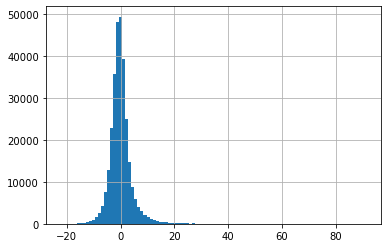

In [27]:
# histogram of the residuals
resids_and_fitted['resids'].hist(bins=100)

# Second Stage Regression

- Stage 1 of the least squares regression: $\widehat{PM}_{2.5}=\beta_0 + \beta_1 \theta_{downstream} + \beta_{2}year + \beta_{3}month + \beta_{4}county + \epsilon$
  - $\theta_{downstream}$ = Instrument = `avg_wind_alignment_cosine`. But this right hand side of the equation should also include all other exogenous (x) vars. 

- Stage 2 of the equation: $Y=\frac{\sum diagnoses}{Pop_{zipcode, 0-19}}=\delta_0 + \delta_1 \widehat{PM}_{2.5} + \delta_{2}year + \delta_{3}month + \delta_{4}county + \epsilon$


In addition to this two stage framework, also run the stage 2 regression using true pm2.5 values. So we can see how biased the coefficient is. 

In [78]:
# drop instrument, and add x_hat to the X matrix
X = X.drop(columns='avg_wind_alignment_cosine')
X['yhat_pm25'] = df['yhat_pm25']
X = X[['yhat_pm25'] + [i for i in X.columns if not re.search('yhat_pm25', i)]] # put our pred pm25 in front
X_truepm25 = pd.concat([df['pm25'], X.drop(columns='yhat_pm25')], axis = 1)

In [80]:
# fit model
fit2_hema = sm.OLS(df['y_hematopoietic'], X).fit()

# save model
if save_results:
  fit2_hema.save(os.path.join(fitted_models_path, 'stage2_ols_hematopoietic.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_hematopoietic'] = fit2_hema.fittedvalues.values

# Get residuals
resids_and_fitted_hema = pd.DataFrame({'resids': fit2_hema.resid, 'fitted': fit2_hema.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_hema).head(1))

# fit model with true pm2.5
fit2_hema_truepm25 = sm.OLS(df['y_hematopoietic'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_hema_truepm25).head(1))

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  0.014766  0.746467    -0.074753     0.104285

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0     pm25 -0.001303  0.091689    -0.002818     0.000211


In [81]:
# fit model
fit2_vasc = sm.OLS(df['y_vasculitis'], X).fit()

# save model
if save_results:
  fit2_vasc.save(os.path.join(fitted_models_path, 'stage2_ols_vasculitis.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_vasculitis'] = fit2_vasc.fittedvalues.values

# Get residuals
resids_and_fitted_vasc = pd.DataFrame({'resids': fit2_vasc.resid, 'fitted': fit2_vasc.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_vasc).head(1))

# fit model with true pm2.5
fit2_vasc_truepm2 = sm.OLS(df['y_vasculitis'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_vasc_truepm2).head(1))

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -0.113818  0.000488    -0.177789    -0.049846

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0     pm25 -0.002363  0.000019    -0.003445    -0.001281


In [82]:
# fit model
fit2_diab = sm.OLS(df['y_diabetes'], X).fit()

# save model
if save_results:
  fit2_diab.save(os.path.join(fitted_models_path, 'stage2_ols_diabetes.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_diabetes'] = fit2_diab.fittedvalues.values

# Get residuals
resids_and_fitted_diab = pd.DataFrame({'resids': fit2_diab.resid, 'fitted': fit2_diab.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_diab).head(1))

# fit model with true pm2.5
fit2_diab_truepm2 = sm.OLS(df['y_diabetes'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_diab_truepm2).head(1))

yhat pm2.5:
    variable     coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  0.00178  0.957486    -0.063674     0.067234

true pm2.5:
  variable      coef       p_value  95_ci_lower  95_ci_upper
0     pm25 -0.003514  4.993127e-10    -0.004621    -0.002406


In [83]:
# fit model
fit2_resp_cardio = sm.OLS(df['y_resp_cardio'], X).fit()

# save model
if save_results:
  fit2_resp_cardio.save(os.path.join(fitted_models_path, 'stage2_ols_resp_cardio.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_resp_cardio'] = fit2_resp_cardio.fittedvalues.values

# Get residuals
resids_and_fitted_resp_cardio = pd.DataFrame({'resids': fit2_resp_cardio.resid, 'fitted': fit2_resp_cardio.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_resp_cardio).head(1))

# fit model with true pm2.5
fit2_resp_cardio_truepm2 = sm.OLS(df['y_resp_cardio'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_resp_cardio_truepm2).head(1))

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -0.934456  0.651216    -4.985799     3.116887

true pm2.5:
  variable      coef        p_value  95_ci_lower  95_ci_upper
0     pm25 -0.952509  1.455942e-163    -1.020963    -0.884054


In [84]:
# fit model
fit2_injuries = sm.OLS(df['y_injuries'], X).fit()

# save model
if save_results:
  fit2_injuries.save(os.path.join(fitted_models_path, 'stage2_ols_injuries.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_injuries'] = fit2_injuries.fittedvalues.values

# Get residuals
resids_and_fitted_injuries = pd.DataFrame({'resids': fit2_injuries.resid, 'fitted': fit2_injuries.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_injuries).head(1))

# fit model with true pm2.5
fit2_injuries_truepm2 = sm.OLS(df['y_injuries'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_injuries_truepm2).head(1))

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -2.401003  0.245584    -6.453816      1.65181

true pm2.5:
  variable      coef        p_value  95_ci_lower  95_ci_upper
0     pm25 -0.870579  7.653733e-137    -0.939073    -0.802086


## All results

In [86]:
all_res_yhat = [get_ols_res(x).head(1) for x in [fit2_hema, fit2_vasc, fit2_diab, fit2_resp_cardio, fit2_injuries]]
all_res_true = [get_ols_res(x).head(1) for x in [fit2_hema_truepm25, fit2_vasc_truepm2, fit2_diab_truepm2, fit2_resp_cardio_truepm2, fit2_injuries_truepm2]]

all_res_yhat = pd.concat(all_res_yhat)
all_res_true = pd.concat(all_res_true)

print("Stage 1 results:")
print(get_ols_res(fit1).head(1))


print("\nStage 2 results:")
df_res = pd.DataFrame({
  'yvar': ['hematopoietic', 'vasculitis', 'diabetes', 'respiratory', 'injuries']
  
  ,'coef_pm25_yhat': all_res_yhat['coef'].values
  ,'pvalue_pm25_yhat': all_res_yhat['p_value'].values
  ,'ci95_lower_pm25_yhat': all_res_yhat['95_ci_lower'].values
  ,'ci95_upper_pm25_yhat': all_res_yhat['95_ci_upper'].values

  ,'coef_pm25_true': all_res_true['coef'].values
  ,'pvalue_pm25_true': all_res_true['p_value'].values
  ,'ci95_lower_pm25_true': all_res_true['95_ci_lower'].values
  ,'ci95_upper_pm25_true': all_res_true['95_ci_upper'].values
})
df_res

Stage 1 results:
                    variable      coef       p_value  95_ci_lower  95_ci_upper
0  avg_wind_alignment_cosine  0.125116  3.576955e-20     0.098463     0.151768

Stage 2 results:


,yvar,coef_pm25_yhat,pvalue_pm25_yhat,ci95_lower_pm25_yhat,ci95_upper_pm25_yhat,coef_pm25_true,pvalue_pm25_true,ci95_lower_pm25_true,ci95_upper_pm25_true
0,hematopoietic,0.014766,0.746467,-0.074753,0.104285,-0.001303,9.168911e-02,-0.002818,0.000211
1,vasculitis,-0.113818,0.000488,-0.177789,-0.049846,-0.002363,1.877234e-05,-0.003445,-0.001281
2,diabetes,0.001780,0.957486,-0.063674,0.067234,-0.003514,4.993127e-10,-0.004621,-0.002406
3,respiratory,-0.934456,0.651216,-4.985799,3.116887,-0.952509,1.455942e-163,-1.020963,-0.884054
4,injuries,-2.401003,0.245584,-6.453816,1.651810,-0.870579,7.653733e-137,-0.939073,-0.802086


# Save data with results

In [34]:
if save_results:
  df.to_csv(os.path.join(data_path, 'modeling_data/modeling_data_results_2022-10-27.csv'), index=False)

# Verify the Exclusion Restriction
- Exclusion restriction: Our instrument (wind bearing) cannot be correlated to the residuals from the 2nd stage regression. 


                    wind_bearing   hema_resids   vasc_resids   diab_resids  \
wind_bearing        1.000000e+00  2.080782e-14 -3.496768e-12 -6.665684e-13   
hema_resids         2.080782e-14  1.000000e+00  3.134830e-02  7.764833e-03   
vasc_resids        -3.496768e-12  3.134830e-02  1.000000e+00  6.953449e-03   
diab_resids        -6.665684e-13  7.764833e-03  6.953449e-03  1.000000e+00   
resp_cardio_resids  1.965432e-13  4.535467e-02  2.619726e-02  3.075421e-02   
injuries_resids    -1.344824e-12  3.846337e-02  2.117591e-02  2.858411e-02   

                    resp_cardio_resids  injuries_resids  
wind_bearing              1.965432e-13    -1.344824e-12  
hema_resids               4.535467e-02     3.846337e-02  
vasc_resids               2.619726e-02     2.117591e-02  
diab_resids               3.075421e-02     2.858411e-02  
resp_cardio_resids        1.000000e+00     4.249348e-01  
injuries_resids           4.249348e-01     1.000000e+00  


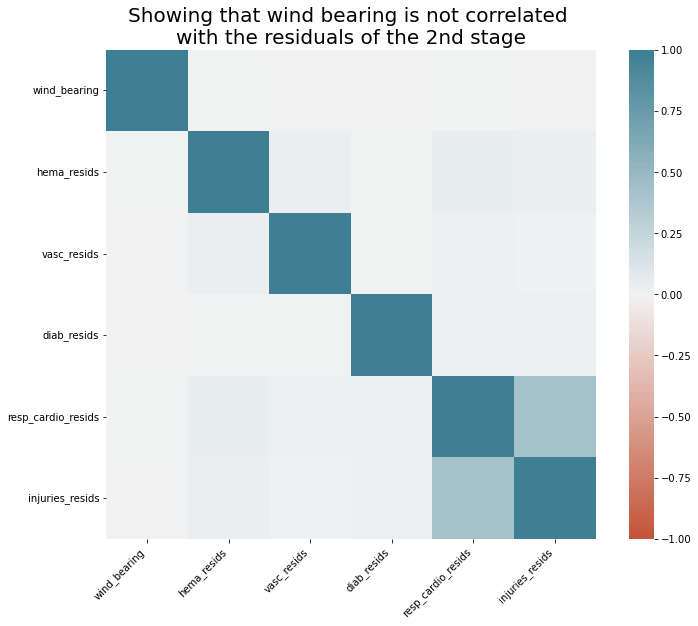

In [35]:
df_corr = pd.DataFrame({
  'wind_bearing': df['avg_wind_alignment_cosine'].values, 
  'hema_resids': resids_and_fitted_hema.resids.values,
  'vasc_resids': resids_and_fitted_vasc.resids.values, 
  'diab_resids': resids_and_fitted_diab.resids.values,
  'resp_cardio_resids': resids_and_fitted_resp_cardio.resids.values,
  'injuries_resids': resids_and_fitted_injuries.resids.values
}).corr()

# plot the results
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_corr, vmin=-1, center=0, vmax=1, cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
    rotation=45, horizontalalignment='right')
ax.set_title("Showing that wind bearing is not correlated \nwith the residuals of the 2nd stage", fontdict = {"fontsize": 20})
print('')

print(df_corr)

# First stage F-test

Run an F test with our instrument to study the impact on the pm2.5. 

In [36]:
# get data into right model form
y, X_null = dmatrices('pm25 ~ 1', data=df, return_type='dataframe')
y, X_instrument = dmatrices('pm25 ~ 1 + avg_wind_alignment_cosine', data=df, return_type='dataframe')

fit_null = sm.OLS(y, X_null).fit()
fit_instrument = sm.OLS(y, X_instrument).fit()

from statsmodels.stats.anova import anova_lm
anovaResults = anova_lm(fit_null, fit_instrument)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,297082.0,1.045505e+07,0.0,NaN,NaN,NaN
1,297081.0,1.045269e+07,1.0,2356.028267,66.961798,2.778973e-16


# Distribution Plots
- These are not yet updated with the additional two diagnosis groups

The disease distributions all on one plot are too hard to visualize.

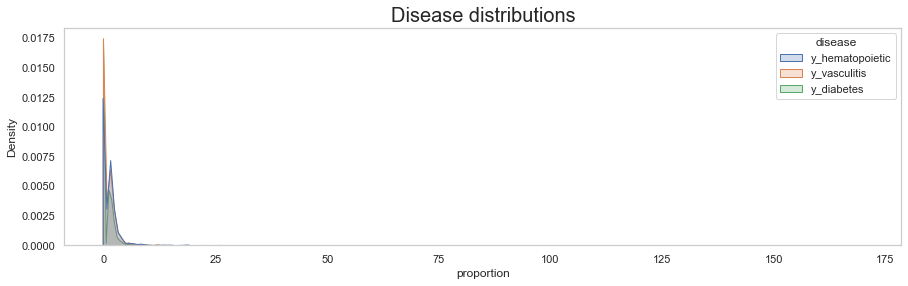

In [38]:
df_melt = pd.melt(df, 
              value_vars=['y_hematopoietic', 'y_vasculitis', 'y_diabetes'], 
              var_name='disease', value_name='proportion')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="proportion", hue='disease', bw_adjust=.8, fill=True)\
  .set_title("Disease distributions", size=20)
print('')

The plot of each disease individually is too hard to see also due to inflated 0's.

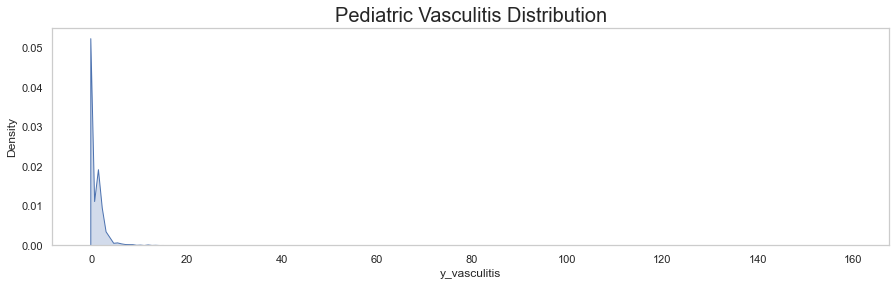

In [39]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="y_vasculitis", bw_adjust=.8, fill=True)\
  .set_title("Pediatric Vasculitis Distribution", size=20)
print('')

Each disease distribution is heavily skewed left, with most values very close to 0. 

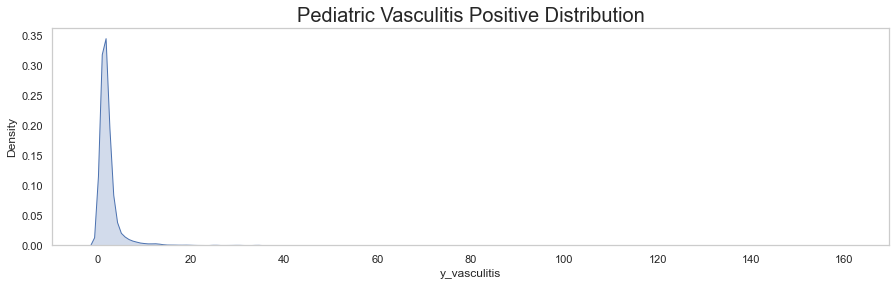

In [40]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_vasculitis']>0], x="y_vasculitis", bw_adjust=.8, fill=True)\
  .set_title("Pediatric Vasculitis Positive Distribution", size=20)
print('')

Plotting the log of each disease distribution, looking at positive cases only is much easier to visualize:

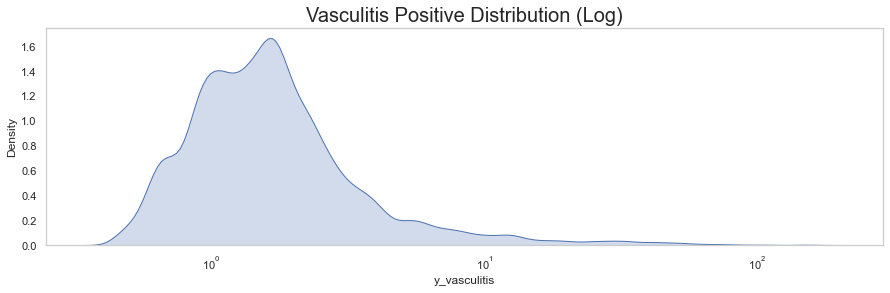

In [41]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_vasculitis']>0], x="y_vasculitis", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Vasculitis Positive Distribution (Log)", size=20)
print('')

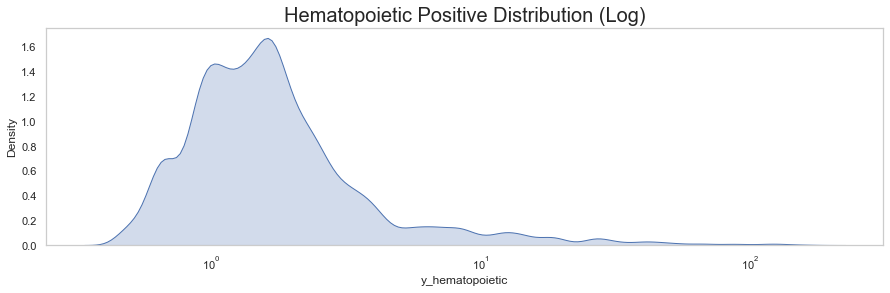

In [42]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_hematopoietic']>0], x="y_hematopoietic", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Hematopoietic Positive Distribution (Log)", size=20)
print('')

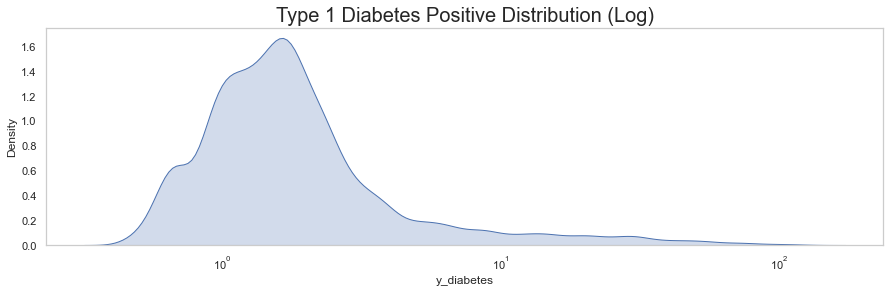

In [43]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_diabetes']>0], x="y_diabetes", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Type 1 Diabetes Positive Distribution (Log)", size=20)
print('')

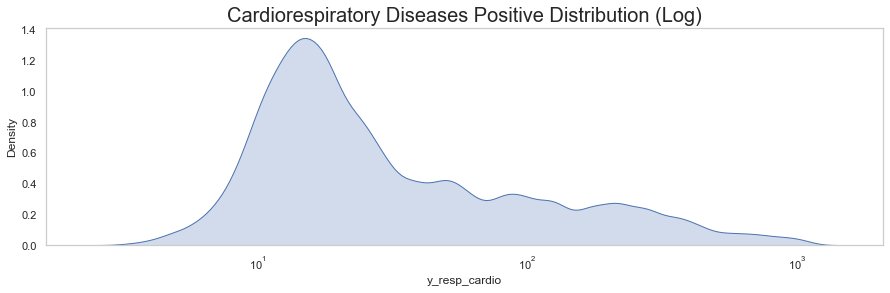

In [44]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_resp_cardio']>0], x="y_resp_cardio", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Cardiorespiratory Diseases Positive Distribution (Log)", size=20)
print('')

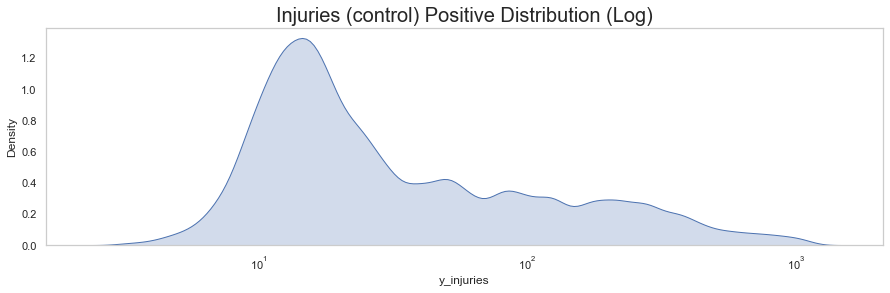

In [45]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_injuries']>0], x="y_injuries", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Injuries (control) Positive Distribution (Log)", size=20)
print('')

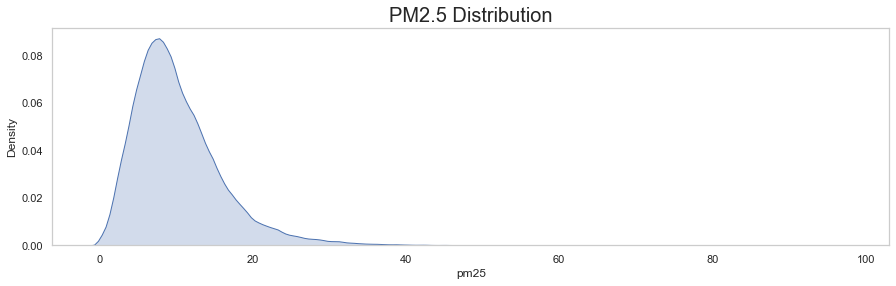

In [46]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="pm25", bw_adjust=.8, fill=True)\
  .set_title("PM2.5 Distribution", size=20)
print('')

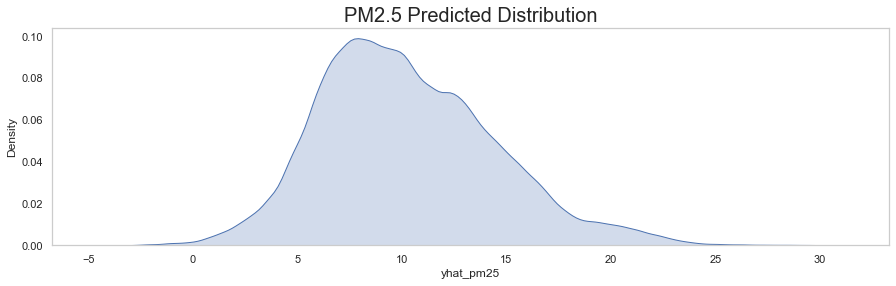

In [47]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="yhat_pm25", bw_adjust=.8, fill=True)\
  .set_title("PM2.5 Predicted Distribution", size=20)
print('')

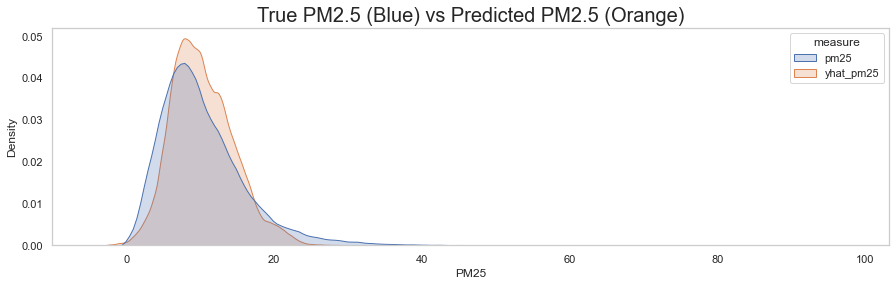

In [48]:
df_melt = pd.melt(df, 
              value_vars=['pm25', 'yhat_pm25'], 
              var_name='measure', value_name='PM25')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="PM25", hue='measure', bw_adjust=.8, fill=True)\
  .set_title("True PM2.5 (Blue) vs Predicted PM2.5 (Orange)", size=20)
print('')

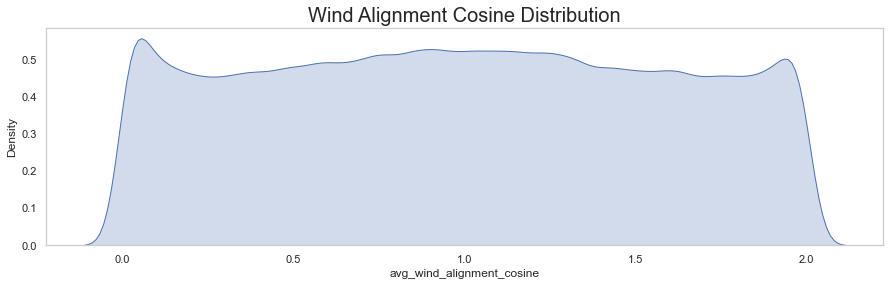

In [49]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="avg_wind_alignment_cosine", bw_adjust=.8, fill=True)\
  .set_title("Wind Alignment Cosine Distribution", size=20)
print('')